In [2]:
!pip install lightgbm

In [3]:
!git clone https://github.com/Keshfer/Chocolate-Rating-ML

Cloning into 'Chocolate-Rating-ML'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 152 (delta 79), reused 74 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 4.26 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [4]:
cd Chocolate-Rating-ML

/content/Chocolate-Rating-ML


In [5]:
# Import approriate functions and packages
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import the dataframe
df = pd.read_csv('cacao_engineered.csv')

# Create X and y training and testing data
X = df.drop(['Rating'], axis=1)
y = df['Rating']

# Clean up columns of X so it works with the model
X.columns = [col.replace(" ", "_").replace(":", "_") for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# Start creating lgb regression model
# Create the lgb Dataset objects to store the training and testing data
train_data = lgb.Dataset(X_train, label = y_train)
test_data = lgb.Dataset(X_test, label = y_test, reference=train_data)

# Set parameters for the lgb regression model
# Objective: Set to regression so that the model tries to predict a regressive value (in this case, quality)
# Metric: The loss metric to be used for the model. Set to mse for now.
# Learning rate: How much to update the trees when refining
# Feature fraction: The percentage of features to take into account when making model, used to prevent overfitting
params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose':-1
}

# Train the actual model, passes in the parameters, training data, the number of rounds to train
num_round = 100  # Number of boosting rounds
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
)

# Predict on the test set, using the best iteration of the model for training
y_pred = model.predict(X_test, num_iteration = model.best_iteration)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.19547680507452356


In [7]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import math

# Create the model
model = LGBMRegressor()

# Parameter grid for grid search algorithm
param_grid = {
    'objective': ['regression'],
    'metric': ['mse'],
    'lambda_l2': [0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 50, 100],
    'max_depth': [-1, 10, 20]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3
)

# Fit the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'feature_fraction': [0.8, 0.9, 1.0],
                         'lambda_l2': [0.1], 'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20], 'metric': ['mse'],
                         'n_estimators': [30, 50, 100],
                         'num_leaves': [20, 31, 40],
                         'objective': ['regression']})

In [8]:
# Print best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# Evaluate on test data
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Display the important metrics
print("Mean squared error:", mse)
print("Root mean squared error:", math.sqrt(mse))

# R^2 score
r2 = r2_score(y_test, y_pred)
adjusted_r2score = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print("Adjusted R^2 score:", adjusted_r2score)

# MAE and MAPE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mape = (abs((y_test - y_pred) / y_test).mean()) * 100
print("Mean Absolute Percentage Error:", mape, "%")

Best Parameters: {'feature_fraction': 0.8, 'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 20, 'metric': 'mse', 'n_estimators': 50, 'num_leaves': 40, 'objective': 'regression'}
Best Score: 0.11746596541815173
Mean squared error: 0.19290720697219907
Root mean squared error: 0.4392120296305636
Adjusted R^2 score: 0.11085180438922104
Mean Absolute Error: 0.33893215870718846
Mean Absolute Percentage Error: 11.910212699452485 %


In [11]:
import joblib

joblib.dump(best_model, 'lightgbm_model.pkl')

from google.colab import drive
drive.mount('/content/drive')
joblib.dump(model, '/content/drive/MyDrive/best_model.pkl')  # Save to your Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/best_model.pkl']

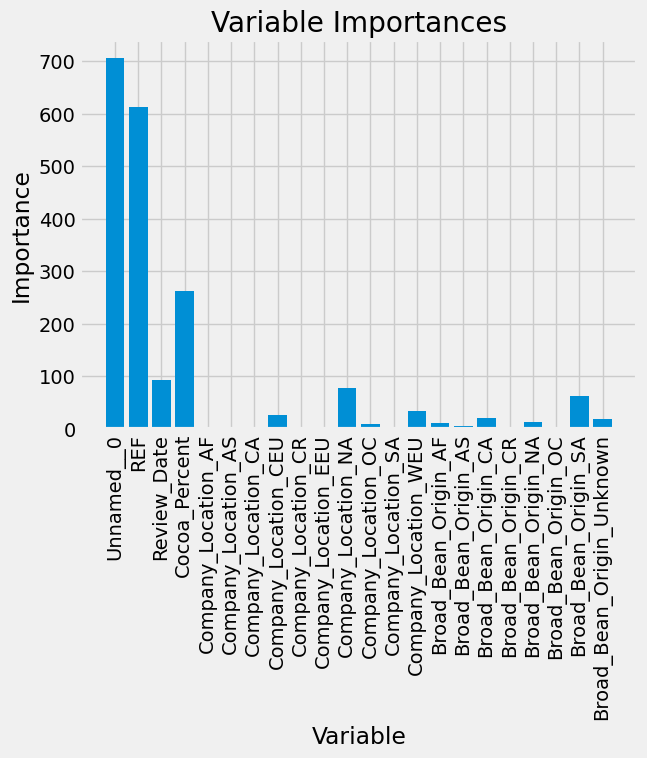

In [15]:
import matplotlib.pyplot as plt

importances = best_model.feature_importances_

plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, best_model.feature_name_, rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');